In [183]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine
import torchinfo


In [184]:
#VGG16, GoogLenet, AlexNet, ResNeXt, efficientnet and DenseNet are the architectures

In [185]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [186]:
data_path = Path("data/")
image_path = data_path / "soil_low_med_high"

In [187]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [188]:
#HyperParameters
batch_Size = 5
learning_rate = 0.001
epochS = 10
dropout_prob = 0.2

In [189]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [190]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=batch_Size) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1a199faff80>,
 ['high', 'low', 'medium'])

In [191]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

In [192]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [193]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_prob, inplace=True), 
    nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [194]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [195]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:18<02:44, 18.32s/it]

Epoch: 1 | train_loss: 1.0485 | train_acc: 0.4235 | test_loss: 1.0369 | test_acc: 0.4000


 20%|██        | 2/10 [00:37<02:29, 18.74s/it]

Epoch: 2 | train_loss: 0.9375 | train_acc: 0.5588 | test_loss: 0.9280 | test_acc: 0.5800


 30%|███       | 3/10 [00:56<02:12, 18.88s/it]

Epoch: 3 | train_loss: 0.8631 | train_acc: 0.6147 | test_loss: 0.8272 | test_acc: 0.6600


 40%|████      | 4/10 [01:16<01:55, 19.32s/it]

Epoch: 4 | train_loss: 0.7375 | train_acc: 0.7235 | test_loss: 0.8812 | test_acc: 0.6200


 50%|█████     | 5/10 [01:35<01:36, 19.30s/it]

Epoch: 5 | train_loss: 0.6796 | train_acc: 0.7735 | test_loss: 0.7821 | test_acc: 0.6200


 60%|██████    | 6/10 [01:55<01:17, 19.48s/it]

Epoch: 6 | train_loss: 0.6739 | train_acc: 0.7265 | test_loss: 0.7479 | test_acc: 0.6400


 70%|███████   | 7/10 [02:15<00:58, 19.58s/it]

Epoch: 7 | train_loss: 0.5622 | train_acc: 0.8118 | test_loss: 0.7067 | test_acc: 0.6200


 80%|████████  | 8/10 [02:37<00:40, 20.29s/it]

Epoch: 8 | train_loss: 0.5797 | train_acc: 0.8059 | test_loss: 0.6405 | test_acc: 0.7600


 90%|█████████ | 9/10 [02:58<00:20, 20.57s/it]

Epoch: 9 | train_loss: 0.5552 | train_acc: 0.8353 | test_loss: 0.7496 | test_acc: 0.7200


100%|██████████| 10/10 [03:18<00:00, 19.82s/it]

Epoch: 10 | train_loss: 0.5445 | train_acc: 0.8529 | test_loss: 0.6963 | test_acc: 0.7200
[INFO] Total training time: 198.219 seconds


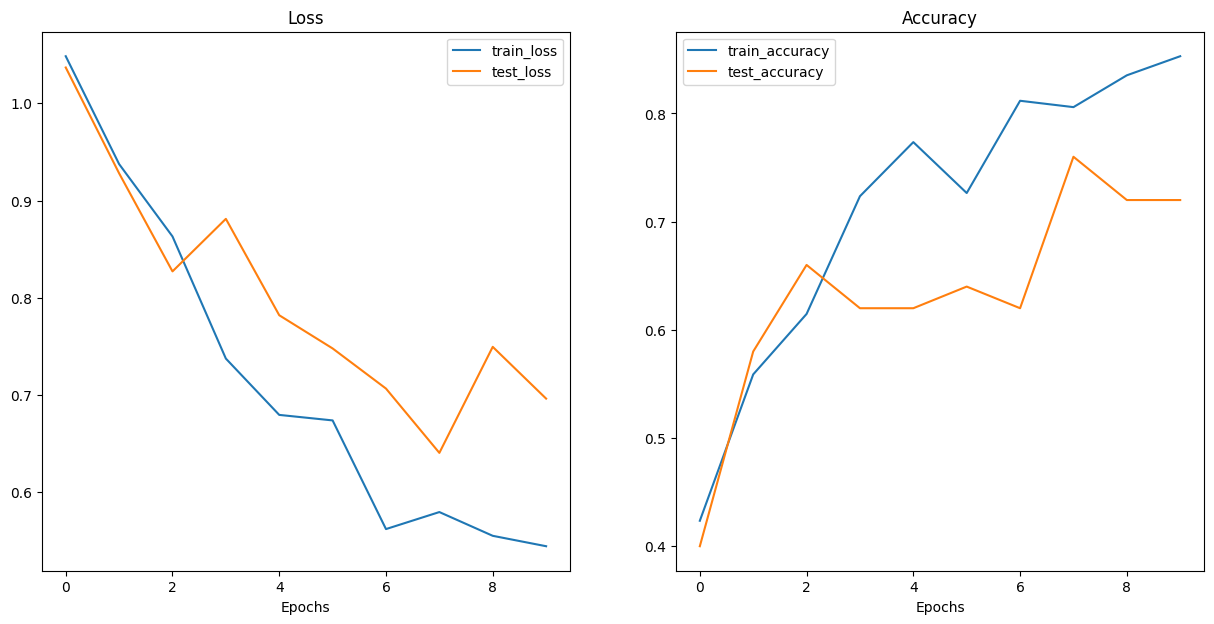

In [196]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)